# Natural Language Entity Extraction
Extracting Ground Truth Labels from Radiology Reports
<hr/>

<img src="example-report.png" width="30%" align="right" style="padding-left:20px">

In this assignment you'll learn to extract information from unstructured medical text. In particular, you'll learn about the following topics:

- Extracting disease labels from clinical reports
    - Text matching
    - Evaluating a labeler
    - Negation detection
    - Dependency parsing
- Question Answering with BERT
    - Preprocessing text for input
    - Extracting answers from model output 

This assignment is inspired by the [work](https://arxiv.org/abs/1901.07031) done by Irvin et al and you should be well positioned to read and understand this manuscript by the end of the assignment. 


<a href="https://ieeexplore.ieee.org/document/7780643">Image Credit</a>


### This assignment covers the folowing topics:


- [1. Extracting Labels](#1)
  - [1.1 Text Matching](#1-1)
      - [Exercise 1](#ex-01)
  - [1.2 Evaluating The Performance](#1-2)      
  - [1.3 Cleanup](#1-3)
  - [1.4 Finding Negative Mentions](#1-4)
      - [Exercise 2](#ex-02)
  - [1.5 Dependency Parsing](#1-5)
- [2. Question Answering Using BERT](#2)
  - [2.1 Roadmap](#2-1)
  - [2.2 Preparing The Input](#2-2)
      - [Exercise 3](#ex-03)
  - [2.3 Getting Answer From Model Output](#2-3)
      - [Exercise 4](#ex-04)
      - [Exercise 5](#ex-05)
  - [2.4 Putting It All Together](#2-4)
  - [2.5 Try It Out](#2-5)

## Packages

Import the following libraries for this assignment.

- `matplotlib.pyplot` - standard plotting library
- `nltk` - an NLP package 
- `pandas` - we'll use this to keep track of data
- `tensorflow` - standard deep learning library
- `transformers` - convenient access to pretrained natural language models

In [1]:
import matplotlib.pyplot as plt
import nltk 
import pandas as pd
import tensorflow as tf
import numpy as np
from transformers import *

Additionally, load the helper `util` library that we have prepared for this assignment in order to abstract some of the details. 
- We do encourage you to review the `util.py` file to learn more about the utility functions behind the scene.

In [2]:
import util
from util import *

<a name="1"></a>
## 1 Extracting Labels

In this part of the assignment, you'll extract disease labels for patients from unstructured clinical reports.  Unlike most assignments, instead of "learning" from the dataset, you will primarily build different "rules" that help us extract knowledge from natural language. 
- Because there is less risk of overfitting when using a "rules-based" approach, you will just use one dataset which will also be the test set.

The test set consists of 1,000 X-ray reports that have been manually labeled by a board certified radiologist for the presence or lack of presence of different pathologies. 
- You also have access to the extracted "Impression" section of each report which is the overall summary of the radiologists for each X-ray. 

Have a look at the dataset:

In [3]:
print("test_df size: {}".format(test_df.shape))
test_df.head()

test_df size: (1000, 12)


,Report Impression,Cardiomegaly,Lung Lesion,Airspace Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture
0,"\n \n1.mild pulmonary edema, and cardiomegaly....",True,False,False,True,False,False,True,False,True,False,False
1,\n \n1.unremarkable cardiomediastinal silhouet...,False,False,True,False,False,False,False,False,False,False,True
2,\n1. lines and tubes are unchanged in position...,False,False,True,False,False,False,False,False,False,False,False
3,\n1. postoperative portable film with a right-...,False,False,True,True,False,False,True,True,False,False,False
4,\n \n1.single frontal view of the chest demons...,False,False,True,False,False,False,False,False,True,False,False


Here are a few example impressions

In [4]:
for i in range(3):
    print(f'\nReport Impression {i}:')
    print(test_df.loc[i, 'Report Impression'])


Report Impression 0:

 
1.mild pulmonary edema, and cardiomegaly.  trace pleural fluid 
effusions.
 
2.low lung volumes with minimal basilar atelectasis.
 
3.no new focal consolidation. 
 
4.interval placement of defibrillation pads.  
 


Report Impression 1:

 
1.unremarkable cardiomediastinal silhouette
 
2.diffuse reticular pattern, which can be seen with an atypical 
infection or chronic fibrotic change.  no focal consolidation.
 
3.no pleural effusion or pneumothorax
 
4.mild degenerative changes in the lumbar spine and old right rib 
fractures. 
 


Report Impression 2:

1. lines and tubes are unchanged in position.
2. increasing retrocardiac opacity and left midlung zone opacity.
3. there is a deep left costophrenic sulcus which is increased when
compared with prior films. no definite evidence of left
pneumothorax. clinical correlation is recommended. if clinically
indicated, consider film in expiration or decubitus views.
4. the icu team was informed of these results at 10 am

You can see that these reports are fairly unstructured, which makes information extraction challenging. Your goal will be to extract the presence or absence of different abnormalities from the raw text. 

Next, see the distribution of abnormalities in the dataset. We have placed all the names of these abnormalities in a list named `CATEGORIES` and you'll use it as labels the graph below. You will also be using this list in the next coding exercises.

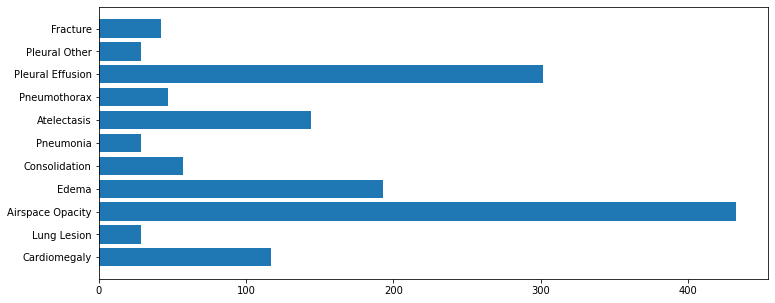

In [5]:
plt.figure(figsize=(12,5))
plt.barh(y=CATEGORIES, width=test_df[CATEGORIES].sum(axis=0))
plt.show()

You can see that pathologies like Airspace Opacity, Pleural Effusion, and Edema are present in many of the reports while Lung Lesion and Pneumonia are not as common in this dataset.

<a name="1-1"></a>
### 1.1 Text Matching
One of the easiest and surprisingly effective ways to label our dataset is to search for presence of different keywords in the impression text. 

We have prepared a list of relevant keywords for each pathology for you to use in detecting the presence of each label. 
- You can access these keywords for each label by calling the `get_mention_keywords(observation)` function.

Here's an example:

In [6]:
cat = CATEGORIES[2]
related_keywords = get_mention_keywords(cat)
print("Related keywords for {} are:\n{}".format(cat, ', '.join(related_keywords)))

Related keywords for Airspace Opacity are:
opaci, decreased translucency, increased density, airspace disease, air-space disease, air space disease, infiltrate, infiltration, interstitial marking, interstitial pattern, interstitial lung, reticular pattern, reticular marking, reticulation, parenchymal scarring, peribronchial thickening, wall thickening, scar


<a name='ex-01'></a>
### Exercise 1: Get Labels

You can use this simple approach to start constructing labels for each report. Fill in the `get_labels()` function below.
- It takes in a report (as an array of sentences)
- It returns a dictionary that maps each category to a boolean value, which indicates the presence or absence of the abnormality.

Note that in Python, the `in` keyword can be used on a string to find substrings.  For instance:

```CPP
s = 'hello how are you? I am fine.'
if "are you" in s:
    print(True)
else:
    print(False)
```
This outputs `True`, because the `in` keyword is able to find substrings.

Also note that whitespace and punctuation matter.

```CPP
s = 'hello how are you? I am fine.'
if "areyou" in s:
    print(True)
else:
    print(False)
```
This outputs `False`, because there only `are you` exists in the string and not `areyou`.

Also, note that the string matching is case sensitive
```CPP
s = 'hello how are you? I am fine.'
if "Hello" in s:
    print(True)
else:
    print(False)
```
This returns `False` because in the string, 'hello' has a lowercase 'h', so `Hello` does not exist in the string.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use the get_mention_keywords() function</li>
    <li>Make sure to make the sentence as well as the phrase all lowercase before looking for the phrase inside the sentence.</li>
</ul>
</p>

In [7]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_labels(sentence_l):
    """
    Returns a dictionary that indicates presence of each category (from CATEGORIES) 
    in the given sentences.
    hint: loop over the sentences array and use get_mention_keywords() function.
    
    Args: 
        sentence_l (array of strings): array of strings representing impression section
    Returns:
        observation_d (dict): dictionary mapping observation from CATEGORIES array to boolean value
    """
    observation_d = {}
    ### START CODE HERE ###
    # loop through each category
    for cat in CATEGORIES:
        
        # Initialize the observations for all categories to be False
        observation_d[cat] = False

    # For each sentence in the list:
    for s in sentence_l: # complete this line
        
        # Set the characters to all lowercase, for consistent string matching
        s = s.lower()
        
        # for each category
        for cat in CATEGORIES: # complete this line
            
            # for each phrase that is related to the keyword (use the given function)
            for phrase in get_mention_keywords(cat): # complete this line
            
                # make the phrase all lowercase for consistent string matching
                phrase = phrase.lower()
                
                # check if the phrase appears in the sentence
                if phrase in s: # complete this line
                    observation_d[cat] = True

    
    ### END CODE HERE ###
    return observation_d

In [8]:
print("Test Case")

test_sentences = ["Diffuse Reticular Pattern, which can be seen with an atypical infection or chronic fibrotic change.", 
                  "no Focal Consolidation."]
print("\nTest Sentences:\n")
for s in test_sentences:
    print(s)

print()
retrieved_labels = get_labels(test_sentences)
print("Retrieved labels: ")

for key, value in sorted(retrieved_labels.items(), key=lambda x: x[0]): 
    print("{} : {}".format(key, value))
print()

print("Expected labels: ")
expected_labels = {'Cardiomegaly': False, 'Lung Lesion': False, 'Airspace Opacity': True, 'Edema': False, 'Consolidation': True, 'Pneumonia': True, 'Atelectasis': False, 'Pneumothorax': False, 'Pleural Effusion': False, 'Pleural Other': False, 'Fracture': False}
for key, value in sorted(expected_labels.items(), key=lambda x: x[0]): 
    print("{} : {}".format(key, value))
print()

for category in CATEGORIES:
    if category not in retrieved_labels:
        print(f'Category {category} not found in retrieved labels. Please check code.')
    
    elif retrieved_labels[category] == expected_labels[category]:
        print(f'Labels match for {category}!')
    
    else:
        print(f'Labels mismatch for {category}. Please check code.')

Test Case

Test Sentences:

Diffuse Reticular Pattern, which can be seen with an atypical infection or chronic fibrotic change.
no Focal Consolidation.

Retrieved labels: 
Airspace Opacity : True
Atelectasis : False
Cardiomegaly : False
Consolidation : True
Edema : False
Fracture : False
Lung Lesion : False
Pleural Effusion : False
Pleural Other : False
Pneumonia : True
Pneumothorax : False

Expected labels: 
Airspace Opacity : True
Atelectasis : False
Cardiomegaly : False
Consolidation : True
Edema : False
Fracture : False
Lung Lesion : False
Pleural Effusion : False
Pleural Other : False
Pneumonia : True
Pneumothorax : False

Labels match for Cardiomegaly!
Labels match for Lung Lesion!
Labels match for Airspace Opacity!
Labels match for Edema!
Labels match for Consolidation!
Labels match for Pneumonia!
Labels match for Atelectasis!
Labels match for Pneumothorax!
Labels match for Pleural Effusion!
Labels match for Pleural Other!
Labels match for Fracture!


##### Note

You may have noticed that the second sentence is "no Focal Consolidation", and that the consolidation label is set to True.  We'll come back to this shortly.

<a name="1-2"></a>
### 1.2 Evaluating The Performance
In order to evaluate the performance of your labeler, you will use a metric called the [F1 score](https://en.wikipedia.org/wiki/F1_score). 
- The F1 score is the harmonic mean of precision and recall. 
- This score is a common metric that is used in information retrieval problems. 

The reason that we care both about precision and recall is that only a small subset of the labels for each report are positive and the rest are negative. 
- So a traditional metric such as accuracy could be very high if you just report every label as False. 
- Precision and recall (summarized in the F1 score) help you measure your classification's performance for both positive cases as well as negative cases.

$$F_1 = \left( \frac{2}{ \frac{1}{recall} + \frac{1}{precision} }\right) = 2 \times \frac{precision \times recall}{precision + recall}$$

We've implemented a utility function for you called `get_f1_table()` below to calculate your function's performance on the whole test set. 
- This function will take advantage of modules from the `bioc` and `negbio` python packages to intelligently split your paragraph to sentences and then apply your function on each sentence. 
- It then returns a table with the calculated F1 score for each category. 
- You can see how this function is implemented in `util.py`.

In [9]:
get_f1_table(get_labels, test_df)

,Label,F1
0,Cardiomegaly,0.718
1,Lung Lesion,0.641
2,Airspace Opacity,0.923
3,Edema,0.708
4,Consolidation,0.270
5,Pneumonia,0.369
6,Atelectasis,0.646
7,Pneumothorax,0.218
8,Pleural Effusion,0.722
9,Pleural Other,0.667


You can see that Airspace Opacity has the highest F1 score at 0.923 while Pneumothorax has the lowest at 0.218. 

These numbers are actually not too bad given the simplicity of this rules-based implemention, but we can do a lot better.

<a name="1-3"></a>
### 1.3 Cleanup

First of all, the text that you use as input is very messy. 
- You should be able to do better by doing some simple pre-processing. 
- We have already implemented the `clean` function for you, which does basic text cleanup. 
- Among other things, it converts pattern such as "and/or" to "or", replaces repeated whitespace with just one space, and removes redundant punctuation, etc. 

Run the following example to see how cleanup changes the input. 

In [10]:
raw_text = test_df.loc[28, 'Report Impression']
print("raw text: \n\n" + raw_text)
print("cleaned text: \n\n" + clean(raw_text))

raw text: 


 
1.  bibasilar opacities, without significant change from the prior 
study, likely representing bilateral pleural effusions with 
atelectasis and/or pneumonia.
 
2.  interval decrease in focal opacification within the right upper 
lung.
 
3.  lines and tubes are unchanged. the distal tip of enteric tube 
remains coiled within the stomach.
 
 

cleaned text: 

1. bibasilar opacities, without significant change from the prior study, likely representing bilateral pleural effusions with atelectasis or pneumonia. 2. interval decrease in focal opacification within the right upper lung. 3. lines and tubes are unchanged. the distal tip of enteric tube remains coiled within the stomach.


Note how the "and/or" in observation 1 was transformed into "or", and the standardization of the whitespace. 

We have implemented a function for this which you can add to the pipeline, by passing the `cleanup=True` flag to our `get_f1_table()` function. Let's see if cleaning up the text can improve performance:

In [11]:
get_f1_table(get_labels, test_df, cleanup=True)

,Label,F1
0,Cardiomegaly,0.725
1,Lung Lesion,0.641
2,Airspace Opacity,0.922
3,Edema,0.707
4,Consolidation,0.270
5,Pneumonia,0.369
6,Atelectasis,0.646
7,Pneumothorax,0.218
8,Pleural Effusion,0.722
9,Pleural Other,0.687


You can see a very modest improvement in Cardiomegaly and Pleural Other, but overall the impact is fairly low. In the next section you'll make a change which has a much bigger impact.

<a name="1-4"></a>
### 1.4 Finding Negative Mentions

<a name='ex-02'></a>
### Exercise 2
So far you have just been treating the presence of a keyword in the impression section as a signal for the presence of that condition in the report. This approach currently has a big problem: 
- This is ignoring negations! 
- For example, consider the following report: "No sign of consolidation". Currently, our matching approach calls this sentence a positive case of consolidation!

Implement your `get_labels()` function one more time.
- Use a boolean "flag" to indicate whether a negation like "no" or "not" appears in a sentence.
- Only set a label to `True` if the word "not" or "no" did not appear in the sentence.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use the get_mention_keywords() function.</li>
</ul>
</p>

In [12]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_labels_negative_aware(sentence_l):
    """
    Returns a dictionary that indicates presence of categories in
    sentences within the impression section of the report.
    Only set a label to True if no 'negative words' appeared in the sentence.
    hint: loop over the sentences array and use get_mention_keywords() function.
    
    Args: 
        sentence_l (array of strings): array of strings representing impression section
    Returns:
        observation_d (dict): dictionary mapping observation from CATEGORIES array to boolean value
    """
    # Notice that all of the negative words are written in lowercase
    negative_word_l = ["no", "not", "doesn't", "does not", "have not", "can not", "can't", "n't"]
    observation_d = {}
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # Initialize the observation dictionary 
    # so that all categories are not marked present.
    for cat in CATEGORIES: # complete this line
        
        # Initialize category to not present.
        observation_d[cat] = False

    # Loop through each sentence in the list of sentences
    for s in sentence_l: # complete this line
        
        # make the sentence all lowercase
        s = s.lower()
        
        # Initialize the flag to indicate no negative mentions (yet)
        negative_flag = False
        
        # Go through all the negative words in the list
        for neg in negative_word_l: # complete this line
            
            # Check if the word is a substring in the sentence
            if neg in s: # complete this line
                # set the flag to indicate a negative mention
                negative_flag = True
                
                # Once a single negative mention is found,
                # you can stop checking the remaining negative words
                break # complete this line

        # When a negative word was not found in the sentence,
        # check for the presence of the diseases
        if not negative_flag: # complete this line
            
            # Loop through the categories list
            for cat in CATEGORIES: # complete this line
                
                # Loop through each phrase that indicates this category
                for phrase in get_mention_keywords(cat): # complete this line

                        # make the phrase all lowercase
                        phrase = phrase.lower()
                        
                        # Check if the phrase is a substring in the sentence
                        if phrase in s: # complete this line
                            
                            # Set the observation dictionary
                            # to indicate the presence of this category
                            observation_d[cat] = True


    ### END CODE HERE ###
    
    return observation_d

In [13]:
print("Test Case")

test_sentences = ["Diffuse Reticular pattern, which can be seen with an atypical infection or chronic fibrotic change.", 
                  "No Focal Consolidation."]
print("\nTest Sentences:\n")
for s in test_sentences:
    print(s)

print()
retrieved_labels = get_labels_negative_aware(test_sentences)
print("Retrieved labels: ")

for key, value in sorted(retrieved_labels.items(), key=lambda x: x[0]): 
    print("{} : {}".format(key, value))
print()

print("Expected labels: ")
expected_labels = {'Cardiomegaly': False, 'Lung Lesion': False, 'Airspace Opacity': True, 'Edema': False, 'Consolidation': False, 'Pneumonia': True, 'Atelectasis': False, 'Pneumothorax': False, 'Pleural Effusion': False, 'Pleural Other': False, 'Fracture': False}
for key, value in sorted(expected_labels.items(), key=lambda x: x[0]): 
    print("{} : {}".format(key, value))
print()

print("Test Results:")
for category in CATEGORIES:
    if category not in retrieved_labels:
        print(f'Category {category} not found in retrieved labels. Please check code.')
    
    elif retrieved_labels[category] == expected_labels[category]:
        print(f'Labels match for {category}!')
    
    else:
        print(f'Labels mismatch for {category}. Please check code.')

Test Case

Test Sentences:

Diffuse Reticular pattern, which can be seen with an atypical infection or chronic fibrotic change.
No Focal Consolidation.

Retrieved labels: 
Airspace Opacity : True
Atelectasis : False
Cardiomegaly : False
Consolidation : False
Edema : False
Fracture : False
Lung Lesion : False
Pleural Effusion : False
Pleural Other : False
Pneumonia : True
Pneumothorax : False

Expected labels: 
Airspace Opacity : True
Atelectasis : False
Cardiomegaly : False
Consolidation : False
Edema : False
Fracture : False
Lung Lesion : False
Pleural Effusion : False
Pleural Other : False
Pneumonia : True
Pneumothorax : False

Test Results:
Labels match for Cardiomegaly!
Labels match for Lung Lesion!
Labels match for Airspace Opacity!
Labels match for Edema!
Labels match for Consolidation!
Labels match for Pneumonia!
Labels match for Atelectasis!
Labels match for Pneumothorax!
Labels match for Pleural Effusion!
Labels match for Pleural Other!
Labels match for Fracture!


If you implemented this correctly, you should have Consolidation set to **False**, because the test sentence contains "No Focal Consolidation.  

With the basic labeling method `get_labels()`, this set Consolidation to True, because it didn't look for 'negative' words.

Check how this changes your aggregate performance:

In [14]:
get_f1_table(get_labels_negative_aware, test_df, cleanup=True)

,Label,F1
0,Cardiomegaly,0.807
1,Lung Lesion,0.465
2,Airspace Opacity,0.905
3,Edema,0.795
4,Consolidation,0.424
5,Pneumonia,0.463
6,Atelectasis,0.642
7,Pneumothorax,0.656
8,Pleural Effusion,0.859
9,Pleural Other,0.621


You should see a generally significant boost in the F1 score across the board. 
- With the `get_labels()` method, Pneumothorax has an F1 score of 0.218.
- With the `get_labels_negative_aware()` method, Pneumothorax has an F1 score of 0.656.

### Fun Exercise
- Try to print some examples for which our rule does not perform well. 
- Can you add other negative words to the list of negative words in order to make the average F1 score better?

In the next section, you'll see how to use some more sophisticated NLP tools to do even better!

<a name="1-5"></a>
### 1.5 Dependency Parsing
Our heuristic for detecting negation is still relatively simple and you can think of some examples that would fool it. To improve performance even further, you'll leverage a more sophisticated approach using a [dependency parser](https://nlp.stanford.edu/software/nndep.html). 

<img src="nndep-example.png">

[Image Credit](https://nlp.stanford.edu/software/nndep.html)

A dependency parser extracts the underlying structure of the text, vizualized in the tree diagram above. 
- Using a dependency parser, you can detect the relationship between different words in the sentence and understand which word is affected by negative phrases. 

Implementations of dependency parsers are very complex, but luckily there are some great off-the-shelf tools to do this. 
- One example is [NegBio](https://github.com/ncbi-nlp/NegBio), a package specifically designed for finding negative and uncertain mentions in X-ray radiology reports. 
- In addition to detecting negations, `negbio` can be configured to use a dependency parser that has been specifically trained for biomedical text. 
- This increases our performance given that biomedical text is full of acronyms, nomenclature and medical jargon.

We've configured `negbio` to:
1. Parse sentences using the Bllip parser trained using [David McClosky’s biomedical model](https://nlp.stanford.edu/~mcclosky/biomedical.html)
2. Compute the universal dependency graph of each sentence using Stanford [CoreNLP](https://stanfordnlp.github.io/CoreNLP/)
3. Use a collection of dependency graph rules to detect the negative or positive presence of a phrase based on configurable patterns. It also comes packaged with the negation and uncertainty rules from the CheXpert project.

The catch with this more involved method is that it takes a while (~1.5h on a fast laptop) to run the detection pipeline on the 1000-sample dataset. 
- Hence, you can do your comparison on a smaller subset of the data (200 samples). 

Run the following cells to get predictions using the `negbio` engine 



In [15]:
sampled_test = test_df.sample(200,random_state=0)

The code for applying the dependency is implemented for you with the function `get_negbio_preds`. 
- If you're interested, you can take a look at the implementation in the `utils` file. 

Run the next cell to extract predictions from the sampled test set. 

### Note 
- This should take about **5 minutes** to run.
- If you want to run it again, you may need to restart the kernel (close and re-open the assignment). 
    - If you run it a second time without restarting the kernel you'll get an error message like
    
    ```RuntimeError: Parser is already loaded and can only be loaded once.```

In [16]:
negbio_preds = get_negbio_preds(sampled_test)

100%|██████████| 200/200 [05:33<00:00,  1.67s/it]


Next let's calculate the new F1 scores to see the dependency parser does. 

In [17]:
calculate_f1(sampled_test, negbio_preds)

,Label,F1
0,Cardiomegaly,0.877
1,Lung Lesion,0.889
2,Airspace Opacity,0.952
3,Edema,0.808
4,Consolidation,0.370
5,Pneumonia,0.467
6,Atelectasis,0.725
7,Pneumothorax,0.326
8,Pleural Effusion,0.875
9,Pleural Other,0.588


And finally, let's compare all methods side by side!

In [18]:
basic = get_f1_table(get_labels, sampled_test).rename(columns={"F1": "F1 Basic"})
clean_basic = get_f1_table(get_labels, sampled_test, cleanup=True).rename(columns={"F1": "F1 Cleaned"})
negated_basic = get_f1_table(get_labels_negative_aware, sampled_test, cleanup=True).rename(columns={"F1": "F1 Negative Basic"})
negated_negbio = calculate_f1(sampled_test, negbio_preds).rename(columns={"F1": "F1 Negbio"})

joined_preds = basic.merge(clean_basic, on="Label")
joined_preds = joined_preds.merge(negated_basic, on="Label")
joined_preds = joined_preds.merge(negated_negbio,  on="Label")

joined_preds

,Label,F1 Basic,F1 Cleaned,F1 Negative Basic,F1 Negbio
0,Cardiomegaly,0.758,0.771,0.815,0.877
1,Lung Lesion,0.762,0.762,0.333,0.889
2,Airspace Opacity,0.948,0.948,0.922,0.952
3,Edema,0.759,0.759,0.771,0.808
4,Consolidation,0.260,0.260,0.409,0.370
5,Pneumonia,0.359,0.359,0.467,0.467
6,Atelectasis,0.605,0.605,0.579,0.725
7,Pneumothorax,0.167,0.167,0.600,0.326
8,Pleural Effusion,0.730,0.730,0.839,0.875
9,Pleural Other,0.588,0.556,0.533,0.588


You should see an improvement using the heavier NLP machinery. The F1 for categories, such as Airspace Opacity, Cardiomegaly, Edema, and Pleural Effusion are already fairly high, while others leave something to be desired. To see how you can extend this to improve performance even more, you can take a look at the CheXpert Labeller paper [here]( https://arxiv.org/pdf/1901.07031.pdf). 

When you're ready, move on to the next section to explore AI techniques for querying raw text.

<a name="2"></a>
## 2 Question Answering Using BERT 

In the previous section, you looked at extracting disease labels from radiology reports. That could use a rule-based system because you asked a limited kind of question: "Is the disease present?". 

What if you want to support any question a physician might want to ask? To do this, you'll have to use more recent artificial intelligence techniques and large datasets. 
- In this section, you'll walk you through the pre- and post-processing involved in applying [BERT](https://github.com/google-research/bert) to the problem of question answering. 
- After developing this infrastructure, you'll use the model to answer questions from clinical notes. 

Implementing question answering can take a few steps, even using pretrained models. 
- First retrieve our model and tokenizer. Recall from the lessons that the tokenizer prepares the input, mapping each word to a unique element in the vocabulary and inserting special tokens. 
- Then, the model processes these tokenized inputs to create valuable embeddings and performs tasks such as question answering. 

### Load The Tokenizer

You will use the tokenizer in the next function that you implement.

In [19]:
tokenizer = AutoTokenizer.from_pretrained("./models")

<a name="2-1"></a>
### 2.1 Roadmap

The following function takes in a question and a passage, as well as some hyperparameters, then outputs the answer (according to our model).  You will first implemenet helper functions that will be called by `get_model_answer` and then complete this function using the helper functions.

```CPP
def get_model_answer(model, question, passage, tokenizer, max_seq_length=384):
    """
    # prepare input
    ...
        
    # get scores for start of answer and end of answer
    ...
    # using scores, get most likely answer
    ...
    
    # using span start and end, construct answer as string
    ...
    return answer
```

<a name='2-2'></a>
### 2.2 Preparing The Input

<a name='ex-03'></a>
### Exercise 3: Prepare BERT Input

Your first task will be the prepare the raw passage and question for input into the model. 

Given the strings `p` and `q`, you want to turn them into an input of the following form: 

`[CLS]` `[q_token1]`, `[q_token2]`, ..., `[SEP]` `[p_token1]`, `[p_token2]`, ...

Here, the special characters `[CLS]` and `[SEP]` let the model know which part of the input is the question and which is the answer. 
- The question appears between `[CLS]` and `[SEP]`.
- The answer appears after `[SEP]`

You'll also pad the input to the max input length, since BERT takes in a fixed-length input.

Fill in the function below to prepare input to BERT. You'll return three items. 
- First is `input_ids`, which holds the numerical ids of each token. 
- Second, you'll output the `input_mask`, which has 1's in parts of the input tensor representing input tokens, and 0's where there is padding. 
- Finally, you'll output `tokens`, the output of the tokenizer (including the `[CLS]` and `[SEP]` tokens). You can see exactly what is expected in the test case below.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>The format of the tokens will be <i>[CLS]&lt;question_tokens&gt;[SEP]&lt;answer_tokens&gt;</i></li>
    <li>To generate a list that repeats an item, such as 'a', you can use ['a'] * 4 to get ['a', 'a', 'a', 'a'].</li>
    <li>To create padding, generate a list of zeros: [0,0,...0] and add it to the list that you are padding.</li>
    <li>The number of zeros to pad is the max sequence length minus the length of the list before padding.</li>
</ul>
</p>

In [20]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def prepare_bert_input(question, passage, tokenizer, max_seq_length=384):
    """
    Prepare question and passage for input to BERT. 

    Args:
        question (string): question string
        passage (string): passage string where answer should lie
        tokenizer (Tokenizer): used for transforming raw string input
        max_seq_length (int): length of BERT input
    
    Returns:
        input_ids (tf.Tensor): tensor of size (1, max_seq_length) which holds
                               ids of tokens in input
        input_mask (list): list of length max_seq_length of 1s and 0s with 1s
                           in indices corresponding to input tokens, 0s in
                           indices corresponding to padding
        tokens (list): list of length of actual string tokens corresponding to input_ids
    """
    # tokenize question
    question_tokens = tokenizer.tokenize(question)
    
    # tokenize passage
    passage_token = tokenizer.tokenize(passage)

    # get special tokens 
    CLS = tokenizer.cls_token
    SEP = tokenizer.sep_token
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # manipulate tokens to get input in correct form (not adding padding yet)
    # CLS {question_tokens} SEP {answer_tokens} 
    # This should be a list of tokens
    tokens = [CLS,*question_tokens,SEP,*passage_token]

    
    # Convert tokens into integer IDs.
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Create an input mask which has integer 1 for each token in the 'tokens' list
    input_mask = [1] * len(input_ids)

    # pad input_ids with 0s until it is the max_seq_length
    # Create padding for input_ids by creating a list of zeros [0,0,...0]
    # Add the padding to input_ids so that its length equals max_seq_length
    input_ids = input_ids + ([0] * (max_seq_length - len(input_ids)))
    
    # Do the same to pad the input_mask so its length is max_seq_length
    input_mask = input_mask + ([0] * (max_seq_length - len(input_mask)))

    # END CODE HERE

    return tf.expand_dims(tf.convert_to_tensor(input_ids), 0), input_mask, tokens  

You can test by running it on your sample input.

In [21]:
passage = "My name is Bob."

question = "What is my name?"

input_ids, input_mask, tokens = prepare_bert_input(question, passage, tokenizer, 20)
print("Test Case:\n")
print("Passage: {}".format(passage))
print("Question: {}".format(question))
print()
print("Tokens:")
print(tokens)
print("\nCorresponding input IDs:")
print(input_ids)
print("\nMask:")
print(input_mask)

Test Case:

Passage: My name is Bob.
Question: What is my name?

Tokens:
['[CLS]', 'What', 'is', 'my', 'name', '?', '[SEP]', 'My', 'name', 'is', 'Bob', '.']

Corresponding input IDs:
tf.Tensor(
[[ 101 1327 1110 1139 1271  136  102 1422 1271 1110 3162  119    0    0
     0    0    0    0    0    0]], shape=(1, 20), dtype=int32)

Mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


##### Expected output
```CPP
Passage: My name is Bob.
Question: What is my name?
Tokens:
['[CLS]', 'What', 'is', 'my', 'name', '?', '[SEP]', 'My', 'name', 'is', 'Bob', '.']

Corresponding input IDs:
tf.Tensor(
[[ 101 1327 1110 1139 1271  136  102 1422 1271 1110 3162  119    0    0
     0    0    0    0    0    0]], shape=(1, 20), dtype=int32)

Mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

```

<a name='2-3'></a>
### 2.3 Getting Answer From Model Output

<a name='ex-04'></a>
### Exercise 4: Get Span From Scores

After taking in the tokenized input, the model outputs two vectors. 
- The first vector contains the scores (more formally, logits) for the starting index of the answer. 
    - A higher score means that index is more likely to be the start of the answer span in the passage. 
- The second vector contains the score for the end index of the answer. 

You want to output the span that maximizes the start score and end score. 
- To be valid, the start index has to occur before the end index. Formally, you want to find:

$$\arg\max_{i <= j, mask_i=1, mask_j = 1} start\_scores[i] + end\_scores[j]$$
- In words, this formulas is saying, calculate the sum and start scores of start position 'i' and end position 'j', given the constraint that the start 'i' is either before or at the end position 'j'; then find the positions 'i' and 'j' where this sum is the highest.
- Furthermore, you want to make sure that $i$ and $j$ are in the relevant parts of the input (i.e. where `input_mask` equals 1.)

Fill in the following function to get the best start and end locations given the start and end scores and the input mask. 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    If you're more comfortable manipulating data with numpy, then here are some methods you might find useful:
    <li><i>{tensor}.numpy()</i> - converts a tf.Tensor object to a numpy array</li>
    <li><i>np.argmax()</i> - finds the index of the maximum value in a numpy array</li>
    
</ul>
</p>

In [22]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_span_from_scores(start_scores, end_scores, input_mask, verbose=False):
    """
    Find start and end indices that maximize sum of start score
    and end score, subject to the constraint that start is before end
    and both are valid according to input_mask.

    Args:
        start_scores (list): contains scores for start positions, shape (1, n)
        end_scores (list): constains scores for end positions, shape (1, n)
        input_mask (list): 1 for valid positions and 0 otherwise
    """
    n = len(start_scores)
    max_start_i = -1
    max_end_j = -1
    max_start_score = -np.inf
    max_end_score = -np.inf
    max_sum = -np.inf
    
    # Find i and j that maximizes start_scores[i] + end_scores[j]
    # so that i <= j and input_mask[i] == input_mask[j] == 1
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # set the range for i
    for i in range(n): # complete this line
        
        # set the range for j
        for j in range(i,n): #complete this line

            # both input masks should be 1
            if input_mask[i] == input_mask[j] == 1: # complete this line
                
                # check if the sum of the start and end scores is greater than the previous max sum
                if (start_scores[i] + end_scores[j]) > max_sum: # complete this line

                    # calculate the new max sum
                    max_sum = start_scores[i] + end_scores[j]
        
                    # save the index of the max start score
                    max_start_i = i
                
                    # save the index for the max end score
                    max_end_j = j
                    
                    # save the value of the max start score
                    max_start_val = start_scores[i]
                    
                    # save the value of the max end score
                    max_end_val = end_scores[j]
                                        
    ### END CODE HERE ###
    if verbose:
        print(f"max start is at index i={max_start_i} and score {max_start_val}")
        print(f"max end is at index i={max_end_j} and score {max_end_val}")
        print(f"max start + max end sum of scores is {max_sum}")
    return max_start_i, max_end_j

We can test this out on the following sample start scores and end scores:

In [23]:
start_scores = tf.convert_to_tensor([-1, 2, 0.4, -0.3, 0, 8, 10, 12], dtype=float)
end_scores = tf.convert_to_tensor([5, 1, 1, 3, 4, 10, 10, 10], dtype=float)
input_mask = [1, 1, 1, 1, 1, 0, 0, 0]

start, end = get_span_from_scores(start_scores, end_scores, input_mask, verbose=True)

print("Expected: (1, 4) \nReturned: ({}, {})".format(start, end))

max start is at index i=1 and score 2.0
max end is at index i=4 and score 4.0
max start + max end sum of scores is 6.0
Expected: (1, 4) 
Returned: (1, 4)


##### Expected output

```CPP
max start is at index i=1 and score 2.0
max end is at index i=4 and score 4.0
max start + max end sum of scores is 6.0
Expected: (1, 4) 
Returned: (1, 4)
```

In [24]:
# Test 2

start_scores = tf.convert_to_tensor([0, 2, -1, 0.4, -0.3, 0, 8, 10, 12], dtype=float)
end_scores = tf.convert_to_tensor([0, 5, 1, 1, 3, 4, 10, 10, 10], dtype=float)
input_mask = [1, 1, 1, 1, 1, 0, 0, 0, 0 ]

start, end = get_span_from_scores(start_scores, end_scores, input_mask, verbose=True)

print("Expected: (1, 1) \nReturned: ({}, {})".format(start, end))

max start is at index i=1 and score 2.0
max end is at index i=1 and score 5.0
max start + max end sum of scores is 7.0
Expected: (1, 1) 
Returned: (1, 1)


##### Expected output
```CPP
max start is at index i=1 and score 2.0
max end is at index i=1 and score 5.0
max start + max end sum of scores is 7.0
Expected: (1, 1) 
Returned: (1, 1)
```
If your expected output differes in this second test, please check how you set the range of your for loops.

<a name='ex-05'></a>
### Exercise 05: Post-Processing

Finally, we'll add some post-processing to get the final string. 

In [25]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def construct_answer(tokens):
    """
    Combine tokens into a string, remove some hash symbols, and leading/trailing whitespace.
    Args:
        tokens: a list of tokens (strings)
    
    Returns:
        out_string: the processed string.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # join the tokens together with whitespace
    out_string = " ".join(tokens)
    
    # replace ' ##' with empty string
    out_string = re.sub(' ##','',out_string)
    
    # remove leading and trailing whitespace
    out_string = out_string.strip()

    ### END CODE HERE ###
    
    # if there is an '@' symbol in the tokens, remove all whitespace
    if '@' in tokens:
        out_string = out_string.replace(' ', '')

    return out_string

In [26]:
# Test

tmp_tokens_1 = [' ## hello', 'how ', 'are ', 'you?      ']
tmp_out_string_1 = construct_answer(tmp_tokens_1)

print(f"tmp_out_string_1: {tmp_out_string_1}, length {len(tmp_out_string_1)}")


tmp_tokens_2 = ['@',' ## hello', 'how ', 'are ', 'you?      ']
tmp_out_string_2 = construct_answer(tmp_tokens_2)
print(f"tmp_out_string_2: {tmp_out_string_2}, length {len(tmp_out_string_2)}")


tmp_out_string_1: hello how  are  you?, length 20
tmp_out_string_2: @hellohowareyou?, length 16


##### Expected output
```CPP
tmp_out_string_1: hello how  are  you?, length 20
tmp_out_string_2: @hellohowareyou?, length 16
```

<a name='2-4'></a>
### 2.4 Putting It All Together
The `get_model_answer` function takes all the functions that you've implemented and performs question-answering.

First load the pre-trained model

In [27]:
model = TFAutoModelForQuestionAnswering.from_pretrained("./models")

### Get Model Answer

Using the helper functions that you implemented, fill out the get_model_answer function to create your question-answering system.
- This function has been completed for you, but we recommend reviewing the code to understand what it's doing.

In [28]:
def get_model_answer(model, question, passage, tokenizer, max_seq_length=384):
    """
    Identify answer in passage for a given question using BERT. 

    Args:
        model (Model): pretrained Bert model which we'll use to answer questions
        question (string): question string
        passage (string): passage string
        tokenizer (Tokenizer): used for preprocessing of input
        max_seq_length (int): length of input for model
        
    Returns:
        answer (string): answer to input question according to model
    """ 
    # prepare input: use the function prepare_bert_input
    input_ids, input_mask, tokens = prepare_bert_input(question, passage, tokenizer, max_seq_length)
    
    # get scores for start of answer and end of answer
    # use the model returned by TFAutoModelForQuestionAnswering.from_pretrained("./models")
    # pass in in the input ids that are returned by prepare_bert_input
    start_scores, end_scores = model(input_ids)
    
    # start_scores and end_scores will be tensors of shape [1,max_seq_length]
    # To pass these into get_span_from_scores function, 
    # take the value at index 0 to get a tensor of shape [max_seq_length]
    start_scores = start_scores[0]
    end_scores = end_scores[0]
    
    # using scores, get most likely answer
    # use the get_span_from_scores function
    span_start, span_end = get_span_from_scores(start_scores, end_scores, input_mask)
    
    # Using array indexing to get the tokens from the span start to span end (including the span_end)
    answer_tokens = tokens[span_start:span_end+1]
    
    # Combine the tokens into a single string and perform post-processing
    # use construct_answer
    answer = construct_answer(answer_tokens)
    
    return answer

<a name='2-5'></a>
### 2.5 Try It Out

Now that we've prepared all the pieces, let's try an example from the SQuAD dataset. 

In [29]:
passage = "Computational complexity theory is a branch of the theory \
           of computation in theoretical computer science that focuses \
           on classifying computational problems according to their inherent \
           difficulty, and relating those classes to each other. A computational \
           problem is understood to be a task that is in principle amenable to \
           being solved by a computer, which is equivalent to stating that the \
           problem may be solved by mechanical application of mathematical steps, \
           such as an algorithm."

question = "What branch of theoretical computer science deals with broadly \
            classifying computational problems by difficulty and class of relationship?"

print("Output: {}".format(get_model_answer(model, question, passage, tokenizer)))
print("Expected: Computational complexity theory")

Output: Computational complexity theory
Expected: Computational complexity theory


In [30]:
passage = "The word pharmacy is derived from its root word pharma which was a term used since \
           the 15th–17th centuries. However, the original Greek roots from pharmakos imply sorcery \
           or even poison. In addition to pharma responsibilities, the pharma offered general medical \
           advice and a range of services that are now performed solely by other specialist practitioners, \
           such as surgery and midwifery. The pharma (as it was referred to) often operated through a \
           retail shop which, in addition to ingredients for medicines, sold tobacco and patent medicines. \
           Often the place that did this was called an apothecary and several languages have this as the \
           dominant term, though their practices are more akin to a modern pharmacy, in English the term \
           apothecary would today be seen as outdated or only approproriate if herbal remedies were on offer \
           to a large extent. The pharmas also used many other herbs not listed. The Greek word Pharmakeia \
           (Greek: φαρμακεία) derives from pharmakon (φάρμακον), meaning 'drug', 'medicine' (or 'poison')."

question = "What word is the word pharmacy taken from?"

print("Output: {}".format(get_model_answer(model, question, passage, tokenizer)))
print("Expected: pharma")

Output: pharma
Expected: pharma


Now let's try it on clinical notes. Below we have an excerpt of a doctor's notes for a patient with an abnormal echocardiogram (this sample is taken from [here](https://www.mtsamples.com/site/pages/sample.asp?Type=6-Cardiovascular%20/%20Pulmonary&Sample=1597-Abnormal%20Echocardiogram))

In [31]:
passage = "Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, \
           and valvular insufficiency. The patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. The patient is an 86-year-old female admitted for evaluation of abdominal pain \
           and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. \
           During the hospitalization, the patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. This consultation is for further evaluation in this regard. As per the patient, \
           she is an 86-year-old female, has limited activity level. She has been having shortness of breath \
           for many years. She also was told that she has a heart murmur, which was not followed through \
           on a regular basis."

q1 = "How old is the patient?"
q2 = "Does the patient have any complaints?"
q3 = "What is the reason for this consultation?"
q4 = "What does her echocardiogram show?"
q5 = "What other symptoms does the patient have?"


questions = [q1, q2, q3, q4, q5]

for i, q in enumerate(questions):
    print("Question {}: {}".format(i+1, q))
    print()
    print("Answer: {}".format(get_model_answer(model, q, passage, tokenizer)))
    print()
    print()

Question 1: How old is the patient?

Answer: 86


Question 2: Does the patient have any complaints?

Answer: The patient complains of shortness of breath


Question 3: What is the reason for this consultation?

Answer: further evaluation


Question 4: What does her echocardiogram show?

Answer: severe mitral regurgitation and also large pleural effusion


Question 5: What other symptoms does the patient have?

Answer: colitis and also diverticulitis




Even without fine-tuning, the model is able to reasonably answer most of the questions! Of course, it isn't perfect. For example, it doesn't give much detail for Question 3. To improve performance, you would ideally collect a medical QA dataset and fine tune the model.

Congratulations, you've finished the assignment for Week 2 of Course 3! Well done!